In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)




In [2]:
!pip install pmdarima PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 1.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from pypfopt import EfficientFrontier, risk_models, expected_returns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

2024-11-05 15:50:10.917687: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 15:50:10.999742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 15:50:11.082359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 15:50:11.153517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 15:50:11.173012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 15:50:11.301833: I tensorflow/core/platform/cpu_feature_gu

In [4]:
sp500_companies = pd.read_csv('sp500_companies.csv')
sp500_index = pd.read_csv('sp500_index.csv')
sp500_stocks = pd.read_csv('sp500_stocks.csv')

print(sp500_companies.head())
print(sp500_index.head())
print(sp500_stocks.head())

  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
3      NMS   GOOG          Alphabet Inc.          Alphabet Inc.   
4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   

                   Sector                        Industry  Currentprice  \
0              Technology            Consumer Electronics        222.01   
1              Technology                  Semiconductors        136.05   
2              Technology       Software - Infrastructure        408.46   
3  Communication Services  Internet Content & Information        170.68   
4  Communication Services  Internet Content & Information        169.24   

       Marketcap        Ebitda  Revenuegrowth           City State  \
0  3355858698240  1.346610e+11          0.061      Cupertino    CA   
1  333

**Data Preprocessing**

In [5]:
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

sp500_index = sp500_index.sort_values('Date')
sp500_stocks = sp500_stocks.sort_values('Date')
sp500_companies.fillna(0, inplace=True)
sp500_stocks.fillna(0, inplace=True)

sp500_index.set_index('Date', inplace=True)

**Exploratory Data Analysis (EDA)**

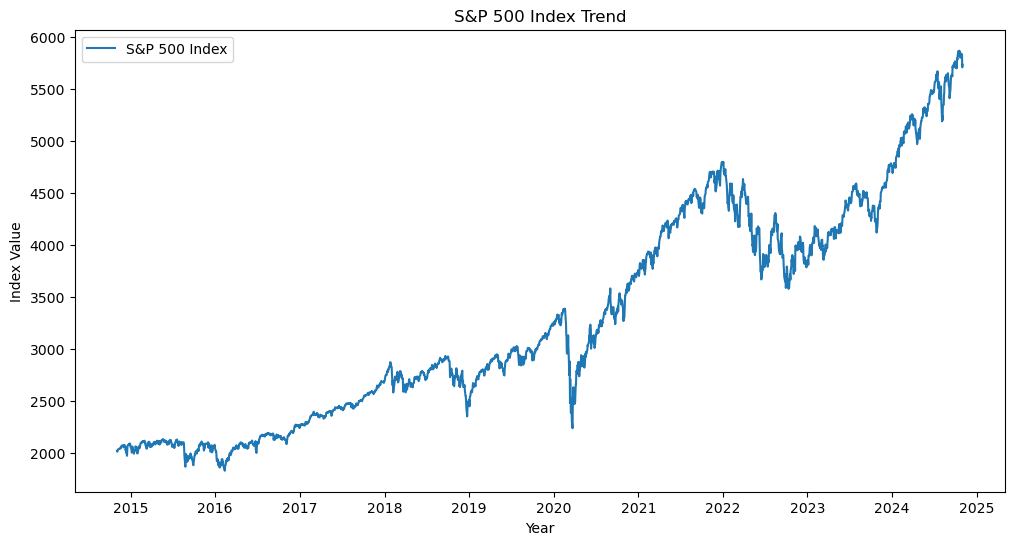

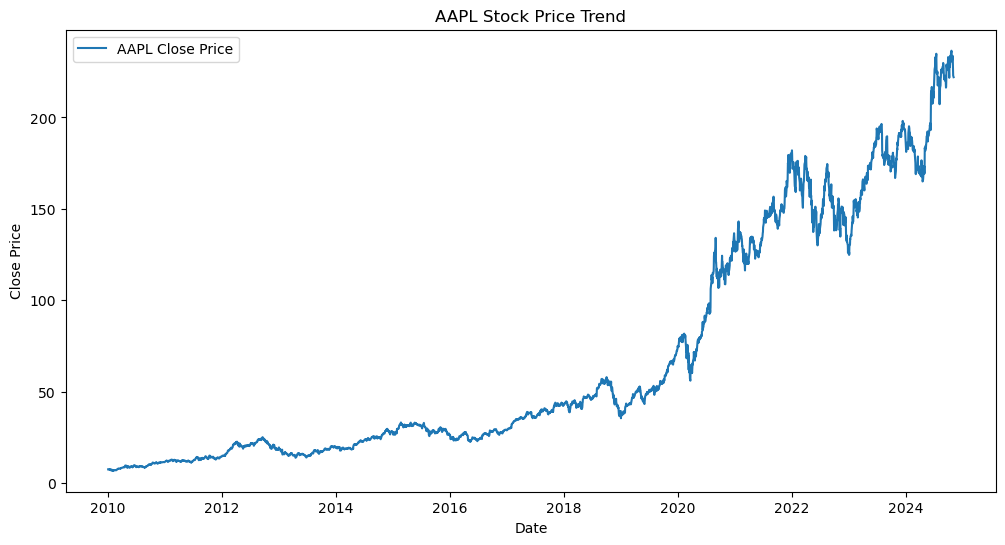

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_index.index, sp500_index['S&P500'], label="S&P 500 Index")
plt.title("S&P 500 Index Trend")
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.show()

aapl_stock = sp500_stocks[sp500_stocks['Symbol'] == 'AAPL']
plt.figure(figsize=(12, 6))
plt.plot(aapl_stock['Date'], aapl_stock['Close'], label='AAPL Close Price')
plt.title('AAPL Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**Time Series Forecasting**

> 1. ARIMA Model for S&P 500 Prediction

ADF Statistic: 0.6332400101365192
p-value: 0.9884069166499614
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25210.873, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25295.255, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25278.680, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25280.137, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25278.308, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25278.494, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=25212.287, Time=1.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25280.680, Time=1.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25277.439, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=25278.958, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25279.439, Time=0.61 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=25214.873, Time=1.52 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25208.323, Time=2.43 sec
 ARIMA(1,0,2)(0,0,0)[0] 

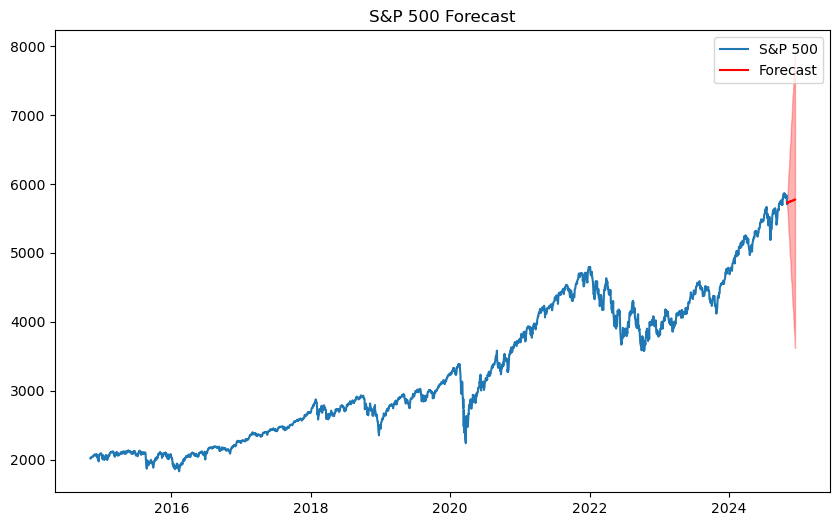

In [7]:
result = sm.tsa.adfuller(sp500_index['S&P500'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

sp500_diff = sp500_index['S&P500'].diff().dropna()

arima_model = auto_arima(sp500_diff, seasonal=False, trace=True, stepwise=True)

n_periods = 30
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
forecast_dates = pd.date_range(sp500_index.index[-1], periods=n_periods, freq='B')

plt.figure(figsize=(10,6))
plt.plot(sp500_index.index, sp500_index['S&P500'], label='S&P 500')
plt.plot(forecast_dates, forecast.cumsum() + sp500_index['S&P500'].iloc[-1], label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0].cumsum() + sp500_index['S&P500'].iloc[-1], 
                 conf_int[:, 1].cumsum() + sp500_index['S&P500'].iloc[-1], color='red', alpha=0.3)
plt.title('S&P 500 Forecast')
plt.legend()
plt.show()

> 2. LSTM Model for Stock Price Prediction

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0071
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.0708e-04
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.7477e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.1625e-04
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.4134e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.8447e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.4186e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.1820e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.9952e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.0261e-04
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


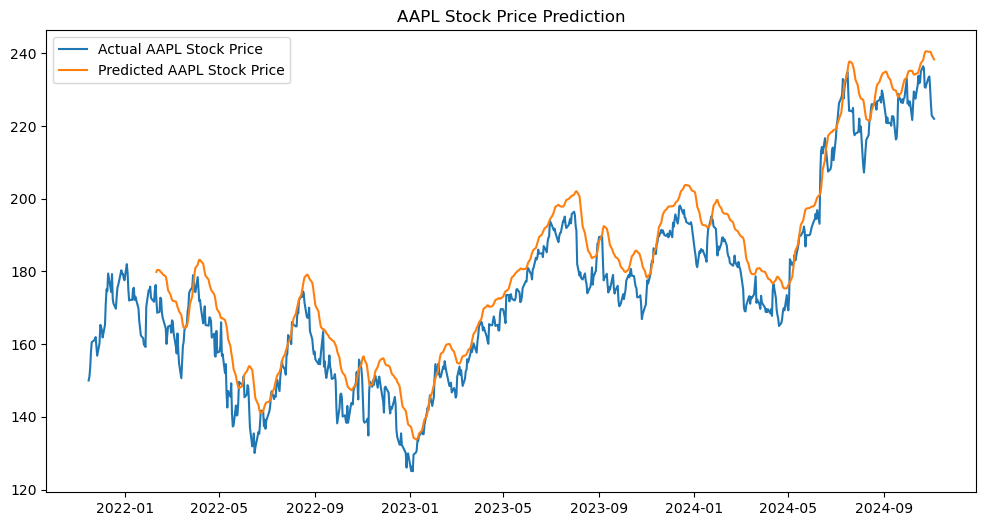

In [8]:
aapl_stock.set_index('Date', inplace=True)
aapl_prices = aapl_stock['Close'].values.reshape(-1,1)

scaler = MinMaxScaler()
aapl_prices_scaled = scaler.fit_transform(aapl_prices)

train_size = int(len(aapl_prices_scaled) * 0.8)
train_data = aapl_prices_scaled[:train_size]
test_data = aapl_prices_scaled[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=32, epochs=10)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(12,6))
plt.plot(aapl_stock.index[train_size:], aapl_stock['Close'][train_size:], label='Actual AAPL Stock Price')
plt.plot(aapl_stock.index[train_size+seq_length:], predictions, label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

**Portfolio Optimization**

In [9]:
stock_prices = sp500_stocks.pivot(index='Date', columns='Symbol', values='Close').dropna()

mean_returns = expected_returns.mean_historical_return(stock_prices)
cov_matrix = risk_models.sample_cov(stock_prices)

ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict({'A': nan, 'AAPL': nan, 'ABBV': nan, 'ABNB': nan, 'ABT': nan, 'ACGL': nan, 'ACN': nan, 'ADBE': nan, 'ADI': nan, 'ADM': nan, 'ADP': nan, 'ADSK': nan, 'AEE': nan, 'AEP': nan, 'AES': nan, 'AFL': nan, 'AIG': nan, 'AIZ': nan, 'AJG': nan, 'AKAM': nan, 'ALB': nan, 'ALGN': nan, 'ALL': nan, 'ALLE': nan, 'AMAT': nan, 'AMCR': nan, 'AMD': nan, 'AME': nan, 'AMGN': nan, 'AMP': nan, 'AMT': nan, 'AMTM': nan, 'AMZN': nan, 'ANET': nan, 'ANSS': nan, 'AON': nan, 'AOS': nan, 'APA': nan, 'APD': nan, 'APH': nan, 'APTV': nan, 'ARE': nan, 'ATO': nan, 'AVB': nan, 'AVGO': nan, 'AVY': nan, 'AWK': nan, 'AXON': nan, 'AXP': nan, 'AZO': nan, 'BA': nan, 'BAC': nan, 'BALL': nan, 'BAX': nan, 'BBY': nan, 'BDX': nan, 'BEN': nan, 'BF-B': nan, 'BG': nan, 'BIIB': nan, 'BK': nan, 'BKNG': nan, 'BKR': nan, 'BLDR': nan, 'BLK': nan, 'BMY': nan, 'BR': nan, 'BRK-B': nan, 'BRO': nan, 'BSX': nan, 'BWA': nan, 'BX': nan, 'BXP': nan, 'C': nan, 'CAG': nan, 'CAH': nan, 'CARR': nan, 'CAT': nan, 'CB': nan, 'CBOE': nan, 'CBRE': n

(nan, nan, nan)

**Model Evaluation**

In [11]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test, predictions)

RMSE: 182.970725064044, MAE: 181.11577020043083, R2: -2547885.5578021514


**Visualization**

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['S&P500'], mode='lines', name='S&P 500'))
fig.update_layout(title='S&P 500 Index Over Time', xaxis_title='Date', yaxis_title='Index Value')
fig.show()

aapl_candlestick = aapl_stock[['Open', 'High', 'Low', 'Close']].copy()
aapl_candlestick['Date'] = aapl_stock.index

fig = go.Figure(data=[go.Candlestick(x=aapl_candlestick['Date'],
                                      open=aapl_candlestick['Open'],
                                      high=aapl_candlestick['High'],
                                      low=aapl_candlestick['Low'],
                                      close=aapl_candlestick['Close'])])

fig.update_layout(title='AAPL Stock Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


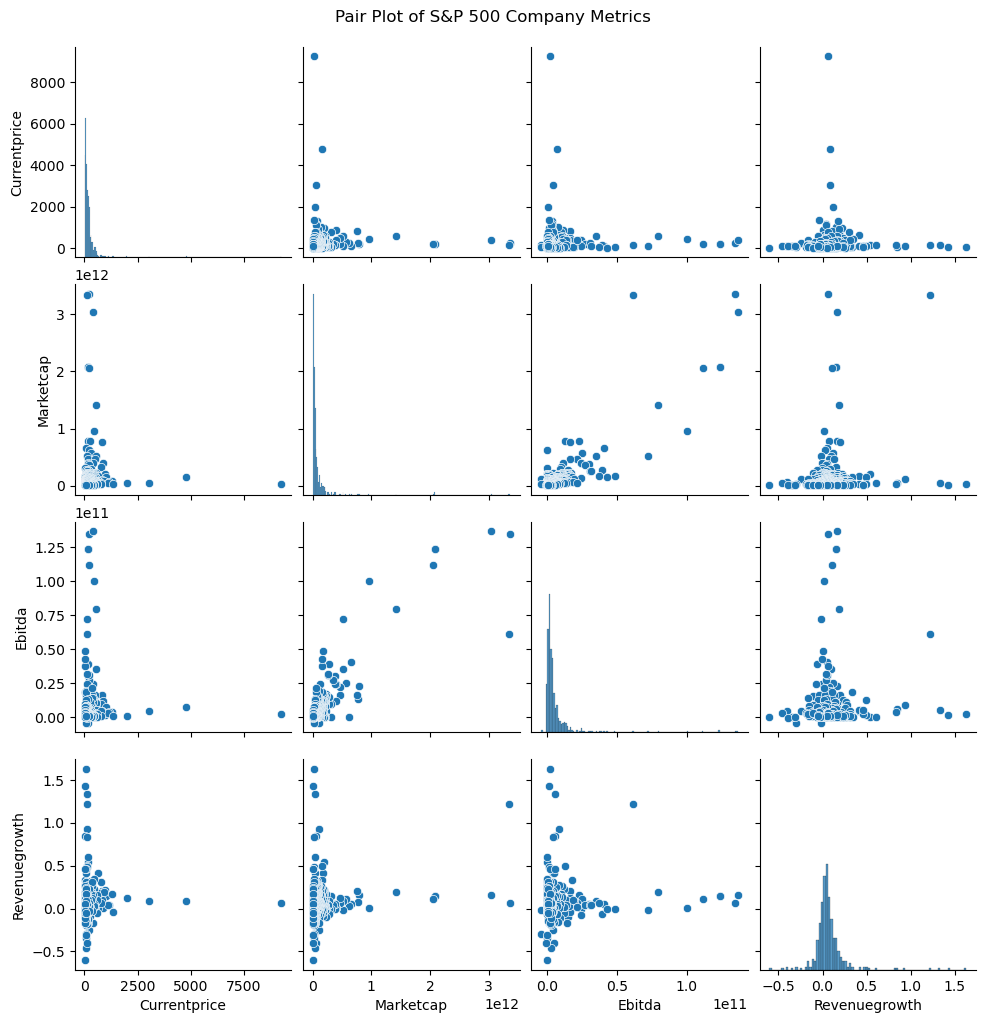

In [13]:
sns.pairplot(sp500_companies[['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth']])
plt.suptitle('Pair Plot of S&P 500 Company Metrics', y=1.02)
plt.show()